In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Necessary Libraries

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import shutil
import random
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop


from sklearn.model_selection import train_test_split


autotune = tf.data.AUTOTUNE

os.environ["KERAS_BACKEND"] = "tensorflow"

## Importing the Data

In [ ]:
os.makedirs("/content/Deep_Learning_coursework/bird", exist_ok=True)
!unzip /content/drive/MyDrive/deep_learning/bird_CUB_200_2011.zip -d /content/Deep_Learning_coursework/bird

Streaming output truncated to the last 5000 lines.
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0067_112913.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0073_112745.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0074_111997.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0080_111099.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0082_112478.jpg  
  inflating: /content/Deep_Learning_coursework/bird/CUB_200_2011/images/118.House_Sparrow/House

In [ ]:

# Defining paths for the Train, test and validation folders
dataset_path = "/content/Deep_Learning_coursework/bird/CUB_200_2011/images"
test_path = "/content/Deep_Learning_coursework/bird/CUB_200_2011/test_images"
val_path = "/content/Deep_Learning_coursework/bird/CUB_200_2011/val_images"
train_path = "/content/Deep_Learning_coursework/bird/CUB_200_2011/train_images"

# Collecting all image paths and corresponding labels
image_paths = []
labels = []

# Selecting 20 random classes ( to save computing time)
all_classes = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
selected_classes = random.sample(all_classes, 20)

for class_folder in selected_classes:
    class_path = os.path.join(dataset_path, class_folder)
    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_folder)  # Class label is the folder name

# Converting to DataFrame for easier handling
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Stratified split (50% test, 40% train, 10% val)
test_df, temp_df = train_test_split(df, test_size=0.5, stratify=df['label'], random_state=26)
train_df, val_df = train_test_split(temp_df, test_size=0.2, stratify=temp_df['label'], random_state=26)

# This function will move the images to the intented folders
def image_folder(df, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for label in df['label'].unique():
        class_dir = os.path.join(dest_dir, label)
        os.makedirs(class_dir, exist_ok=True)

    for _, row in df.iterrows():
        shutil.move(row['image_path'], os.path.join(dest_dir, row['label'], os.path.basename(row['image_path'])))

# Moving images to respective folders
image_folder(train_df, train_path)
image_folder(val_df, val_path)
image_folder(test_df, test_path)

In [ ]:
# Loading Training Data (from "train_images/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=26,
    image_size=(256, 256),
    batch_size=32
)

# Loading Validation Data (from "val_images/")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=26,
    image_size=(256, 256),
    batch_size=32
)

# Loading Test Data (from "test_images/")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=26,
    image_size=(256, 256),
    batch_size=32
)

print(f"Train: {len(train_ds)} batches, Val: {len(val_ds)} batches, Test: {len(test_ds)} batches")


Found 472 files belonging to 20 classes.
Found 119 files belonging to 20 classes.
Found 591 files belonging to 20 classes.
Train: 15 batches, Val: 4 batches, Test: 19 batches


## Pre-processing the image

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flipping horizontally
    tf.keras.layers.RandomRotation(0.2),  # Rotating up to 20%
    tf.keras.layers.RandomZoom(0.2),  # Zooming up to 20%
    tf.keras.layers.RandomContrast(0.2),  # Adjusting contrast
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Shifting image
    tf.keras.layers.RandomBrightness(0.2),  # Adjusting brightness
    tf.keras.layers.GaussianNoise(0.05),  # Adding slight Gaussian noise
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

num_classes = 20 # Defining the number of classes for one-hot encoding
# Applying data augmentation and one hot encoding
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), tf.one_hot(y, depth=num_classes)),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=False), tf.one_hot(y, depth=num_classes)),
                        num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=False), tf.one_hot(y, depth=num_classes)),
                        num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
output = Dense(20, activation="softmax")(x)  # 20 classes for bird classification

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 187s 11s/step - accuracy: 0.1235 - loss: 2.8805 - val_accuracy: 0.4958 - val_loss: 2.2328
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 212s 11s/step - accuracy: 0.4776 - loss: 2.1828 - val_accuracy: 0.6134 - val_loss: 1.7076
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 182s 10s/step - accuracy: 0.6026 - loss: 1.7083 - val_accuracy: 0.6723 - val_loss: 1.3772
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 0.6252 - loss: 1.4519 - val_accuracy: 0.7143 - val_loss: 1.1696
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.7268 - loss: 1.2294 - val_accuracy: 0.7563 - val_loss: 1.0162
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 165s 11s/step - accuracy: 0.7719 - loss: 1.0543 - val_accuracy: 0.7983 - val_loss: 0.9092
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.7937 - loss: 0.9418 - val_accuracy: 0.7983 - val_loss: 0.8429
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 215s 11s/step - accuracy: 0.7869 - loss: 0.9022 - val_accuracy: 0.

In [ ]:
# Fine Tuning the transfer learning model
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 209s 12s/step - accuracy: 0.8531 - loss: 0.8367 - val_accuracy: 0.8319 - val_loss: 0.6725
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 197s 11s/step - accuracy: 0.8135 - loss: 0.8689 - val_accuracy: 0.8235 - val_loss: 0.7020
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 164s 11s/step - accuracy: 0.8488 - loss: 0.8236 - val_accuracy: 0.8235 - val_loss: 0.6973
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step - accuracy: 0.8566 - loss: 0.7939 - val_accuracy: 0.8319 - val_loss: 0.6846
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 219s 11s/step - accuracy: 0.8471 - loss: 0.7991 - val_accuracy: 0.8235 - val_loss: 0.6706
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step - accuracy: 0.8104 - loss: 0.8020 - val_accuracy: 0.8403 - val_loss: 0.6603
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.8293 - loss: 0.7741 - val_accuracy: 0.8319 - val_loss: 0.6526
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 163s 11s/step - accuracy: 0.8572 - loss: 0.7870 - val_accuracy: 0.

## Saving the Model

In [ ]:
# Saving the Model
model.save("/content/drive/MyDrive/deep_learning/bird_classifier.keras")


# Model Performance on Test Data

## Retrieving Saved Model

In [ ]:
# Reloading the Model
model = load_model("/content/drive/MyDrive/deep_learning/bird_classifier.keras")


## Predicting using Test data

#### Uncomment for new test data

In [ ]:
# # Path for new test images
# new_test_path = "/content/Deep_Learning_coursework/bird/CUB_200_2011/new_test_images"

# # Loading New Test Data
# def load_new_test_dataset():
#     if not os.path.exists(new_test_path) or not os.listdir(new_test_path):
#         raise ValueError(f"New test directory '{new_test_path}' is empty or does not exist. Please provide test images.")

#     return tf.keras.preprocessing.image_dataset_from_directory(
#         new_test_path,  # Loading from externally provided test folder
#         seed=26,
#         image_size=(256, 256),
#         batch_size=32
#     )

# # Load new test dataset when provided
# test_ds = load_new_test_dataset()

# # Apply preprocessing (e.g., one-hot encoding, augmentation if needed)
# AUTOTUNE = tf.data.AUTOTUNE
# num_classes = 20  # Adjust based on actual class count

# test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=False), tf.one_hot(y, depth=num_classes)),
#                       num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# print(f"Loaded {len(test_ds)} batches of new test images.")


In [ ]:
test_images, test_labels = next(iter(test_ds))  # Retrieving one batch of images for testing
true_classes = np.argmax(test_labels.numpy(), axis=1) # Converting one-hot encoded labels to class indices if needed

# Get model predictions
predictions = model.predict(test_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

## Model Output on Test Data

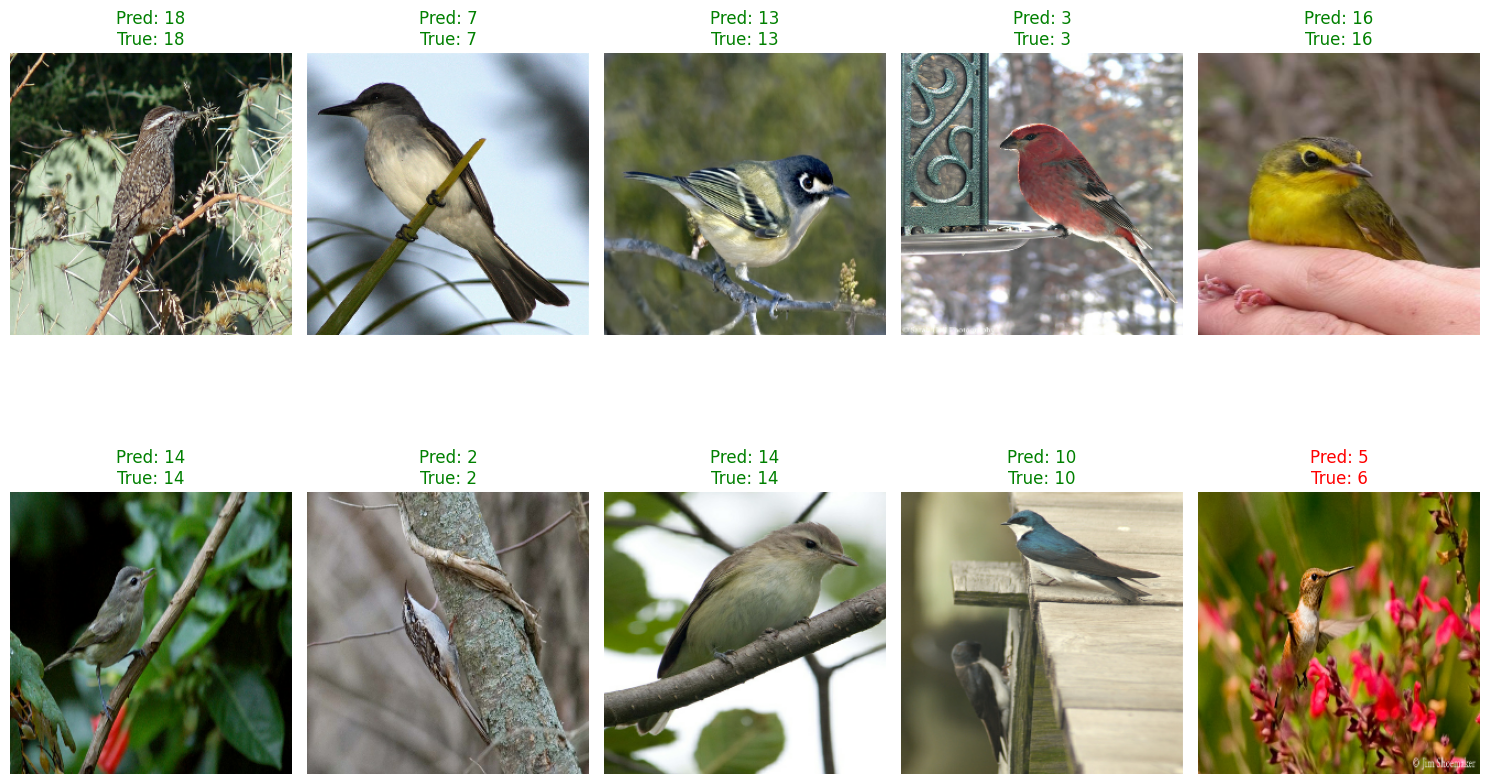

In [ ]:
# Displaying images with their true and predicted labels
num_images = min(10, len(test_images))  # Displaying up to 10 images
plt.figure(figsize=(15, 10))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))  # Converting tensor to image format
    plt.axis("off")

    true_label = true_classes[i]
    pred_label = predicted_classes[i]

    color = "green" if true_label == pred_label else "red" # Red -> False, Green -> True
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

### Performance Metrics

In [ ]:
# Computing and printing performance metrics
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")


precision = precision_score(true_classes, predicted_classes, average='macro',zero_division = 1)
print(f"Precision: {precision:.4f}")


recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall: {recall:.4f}")

Accuracy: 0.9062
Precision: 0.9352
Recall: 0.9028


## Confusion Matrix

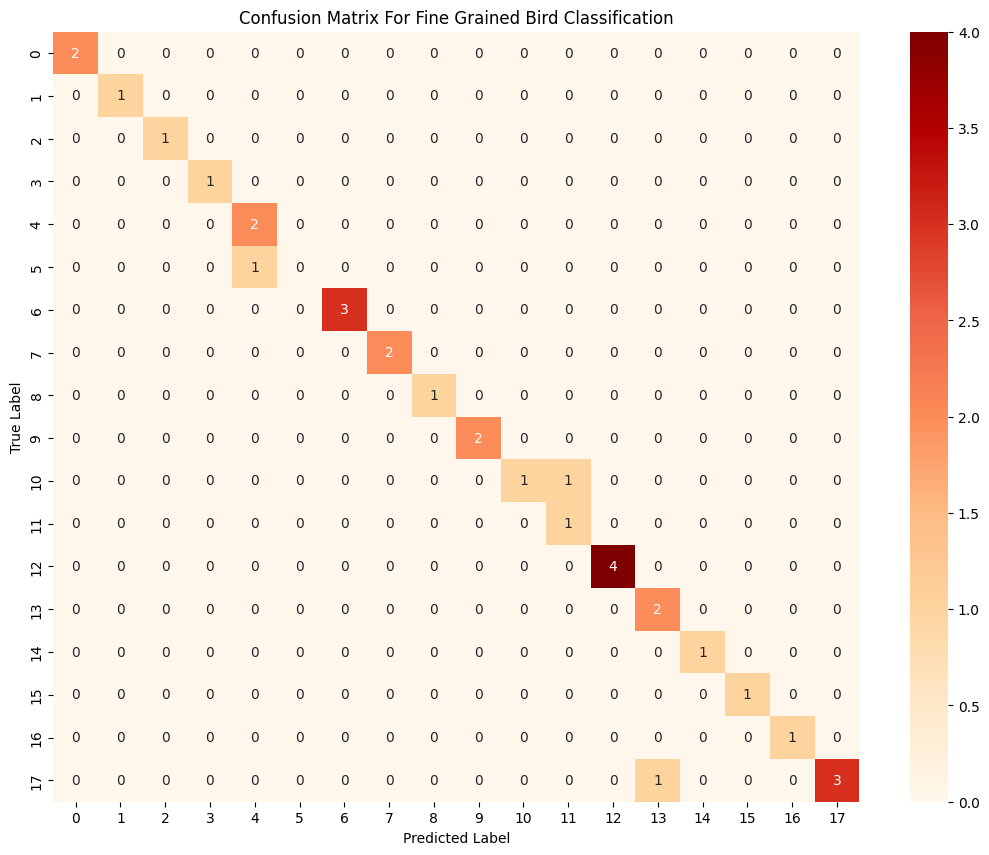

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(13, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix For Fine Grained Bird Classification")
plt.show()